In [ ]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Resize, Grayscale, Normalize
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
import torch.nn.functional as F
from itertools import cycle

# USPS to MNIST

In [ ]:
transform = Compose([
        Resize(size = (28,28)),
        Grayscale(),
        # transforms.RandomCrop(224),
        # transforms.RandomHorizontalFlip(),
        ToTensor(),
        Normalize(mean=[0.5], std=[0.5])
        ])

In [ ]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = transform,
    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = transform
)
target_data = datasets.USPS(
    root='data',
    train=False,
    transform=transform,
    download=True
)

100%|██████████| 9912422/9912422 [00:00<00:00, 57991878.13it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 80811003.22it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24986691.37it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15191809.22it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1831726/1831726 [00:01<00:00, 1614639.35it/s]


In [ ]:
print(test_data)

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=warn)
               Grayscale(num_output_channels=1)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )


In [ ]:
print(target_data)

Dataset USPS
    Number of datapoints: 2007
    Root location: data
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=warn)
               Grayscale(num_output_channels=1)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )


In [ ]:
print(train_data.data.size())
print(train_data.targets.size())

torch.Size([60000, 28, 28])
torch.Size([60000])


In [ ]:
print(train_data.targets[6])

tensor(1)


In [ ]:
# print(target_data.data.size())
print(target_data.data.shape)

(2007, 16, 16)


In [ ]:
loaders = {
    'train' : torch.utils.data.DataLoader(train_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=2),

    'test'  : torch.utils.data.DataLoader(test_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=2),
    'target' : torch.utils.data.DataLoader(target_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=2),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7ce2fe1bbdf0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7ce2fe1bbf70>,
 'target': <torch.utils.data.dataloader.DataLoader at 0x7ce2fe21e950>}

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x    # return x for visualization

In [ ]:
cnn = CNN()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)
num_epochs = 10

In [ ]:
def train(num_epochs, cnn, loader = loaders['train']):

    cnn.train()

    # Train the model
    total_step = len(loader)

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loader):

            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]
            loss = loss_func(output, b_y)

            # clear gradients for this training step
            optimizer.zero_grad()

            # backpropagation, compute gradients
            loss.backward()
            # apply gradients
            optimizer.step()

            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

In [ ]:
train(num_epochs, cnn, loaders["test"])

Epoch [1/10], Step [100/100], Loss: 0.1068
Epoch [2/10], Step [100/100], Loss: 0.1049
Epoch [3/10], Step [100/100], Loss: 0.0671
Epoch [4/10], Step [100/100], Loss: 0.0683
Epoch [5/10], Step [100/100], Loss: 0.0621
Epoch [6/10], Step [100/100], Loss: 0.0005
Epoch [7/10], Step [100/100], Loss: 0.0108
Epoch [8/10], Step [100/100], Loss: 0.0106
Epoch [9/10], Step [100/100], Loss: 0.0027
Epoch [10/10], Step [100/100], Loss: 0.0115


In [ ]:
def test(model, test_loader = loaders['test']):
    # Test the model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            test_output, last_layer = model(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            correct += (pred_y == labels).sum().item()
            total += len(labels)
    accuracy = correct/total
            #accuracy = (pred_y == labels).sum().item() / float(labels.size(0))

    print('Test Accuracy of the model on the ' + str(total) + ' test images: %.2f' % accuracy)

In [ ]:
test(model = cnn)

Test Accuracy of the model on the 10000 test images: 0.99


In [ ]:
test(model = cnn, test_loader = loaders['target'])

Test Accuracy of the model on the 2007 test images: 0.68


---

## After Domain Adaptation

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        return out

In [ ]:
class CycleGANDiscriminator(nn.Module):
    def __init__(self, input_channels):
        super(CycleGANDiscriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=1)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.model(x)
        return self.sigmoid(x)

In [ ]:
# Define the CycleGAN Generator
class CycleGANGenerator(nn.Module):
    def __init__(self, input_channels, num_res_blocks=6):
        super(CycleGANGenerator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm2d(64),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.residual_blocks = nn.Sequential(*[ResidualBlock(256, 256) for _ in range(num_res_blocks)])

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, input_channels, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.residual_blocks(x)
        x = self.decoder(x)
        return x

In [ ]:
import matplotlib.pyplot as plt

def visualize_generated_images(generator, num_images=5):
    generator.eval()  # Set the generator to evaluation mode
    with torch.no_grad():
        for _ in range(num_images):
            # Generate a random input or use a sample from the test dataset
            random_input = torch.randn(1, 1, image_size, image_size).to(device)
            generated_image = generator(random_input)

            # Convert the generated image tensor to a NumPy array
            generated_image_np = generated_image.squeeze().cpu().numpy()

            # Display the generated image using matplotlib
            plt.imshow(generated_image_np, cmap='gray')
            plt.axis('off')
            plt.show()

In [ ]:
# Assuming loaders['train'] is the larger dataset and loaders['target'] is the smaller dataset
source_data_loader = loaders['train']
target_data_loader = iter(cycle(loaders['target']))

# Instantiate the CycleGAN generator (generator_G) and discriminator (discriminator_G)
generator_G = CycleGANGenerator(input_channels=1)
discriminator_G = CycleGANDiscriminator(input_channels=1)

# Move the generator and discriminator to the appropriate device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator_G.to(device)
discriminator_G.to(device)

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)

generator_G.apply(weights_init_normal)
discriminator_G.apply(weights_init_normal)

# Set the generator_G and discriminator_G to training mode
generator_G.train()
discriminator_G.train()

# Define the loss functions and optimizers
criterion_GAN = nn.BCELoss()
criterion_cycle = nn.L1Loss()
optimizer_G = optim.Adam(generator_G.parameters(), lr=0.0005, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator_G.parameters(), lr=0.0001, betas=(0.5, 0.999))

# Training the CycleGAN generator and discriminator
num_epochs = 50

for epoch in range(num_epochs):
    target_data_loader = iter(cycle(loaders['target']))  # Reset target_data_loader at the beginning of each epoch

    for i, source_images in enumerate(source_data_loader):
        source_images = source_images[0].to(device)

        # Dynamically adjust the target batch size to match the source batch size
        target_batch_size = source_images.size(0)
        target_images = []

        while len(target_images) < target_batch_size:
            try:
                target_batch = next(target_data_loader)[0].to(device)
                target_images.extend(target_batch)
            except StopIteration:
                target_data_loader = iter(cycle(loaders['target']))  # Reset target_data_loader if exhausted
                continue

        target_images = torch.stack(target_images[:target_batch_size])

        # Adversarial ground truths
        valid = torch.ones((source_images.size(0), 1, discriminator_G(target_images).size(2), discriminator_G(target_images).size(3)), device=device)
        fake = torch.zeros((source_images.size(0), 1, discriminator_G(target_images).size(2), discriminator_G(target_images).size(3)), device=device)

        optimizer_G.zero_grad()

        # GAN loss
        fake_images = generator_G(source_images)
        pred_fake = discriminator_G(fake_images)
        loss_GAN = criterion_GAN(pred_fake, valid)

        # Cycle loss
        reconstructed_images = generator_G(fake_images)
        loss_cycle = criterion_cycle(reconstructed_images, source_images)

        # Total loss
        lambda_cycle = 5
        loss_G = loss_GAN + lambda_cycle * loss_cycle

        loss_G.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()

        # Real loss
        pred_real = discriminator_G(source_images)
        loss_real = criterion_GAN(pred_real, valid)

        # Fake loss
        pred_fake = discriminator_G(fake_images.detach())
        loss_fake = criterion_GAN(pred_fake, fake)

        # Total loss
        loss_D = 0.5 * (loss_real + loss_fake)

        loss_D.backward()
        optimizer_D.step()

        # Print training information
        if i % 100 == 0:
            print(
                f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(source_data_loader)}] [D loss: {loss_D.item()}] [G loss: {loss_G.item()}]"
            )

[Epoch 0/50] [Batch 0/600] [D loss: 0.7946393489837646] [G loss: 6.076794624328613]
[Epoch 0/50] [Batch 100/600] [D loss: 0.7283543944358826] [G loss: 1.253309726715088]
[Epoch 0/50] [Batch 200/600] [D loss: 0.6930524110794067] [G loss: 1.2392504215240479]
[Epoch 0/50] [Batch 300/600] [D loss: 0.625352144241333] [G loss: 1.3778417110443115]
[Epoch 0/50] [Batch 400/600] [D loss: 0.6096433401107788] [G loss: 1.3409337997436523]
[Epoch 0/50] [Batch 500/600] [D loss: 0.5984024405479431] [G loss: 1.3184573650360107]
[Epoch 1/50] [Batch 0/600] [D loss: 0.6362478733062744] [G loss: 1.3242263793945312]
[Epoch 1/50] [Batch 100/600] [D loss: 0.6667013168334961] [G loss: 1.3064451217651367]
[Epoch 1/50] [Batch 200/600] [D loss: 0.6522871851921082] [G loss: 1.2691234350204468]
[Epoch 1/50] [Batch 300/600] [D loss: 0.6785300970077515] [G loss: 1.2345397472381592]
[Epoch 1/50] [Batch 400/600] [D loss: 0.6598340272903442] [G loss: 1.312556266784668]
[Epoch 1/50] [Batch 500/600] [D loss: 0.63179016113

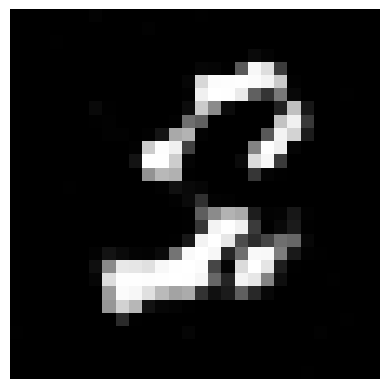

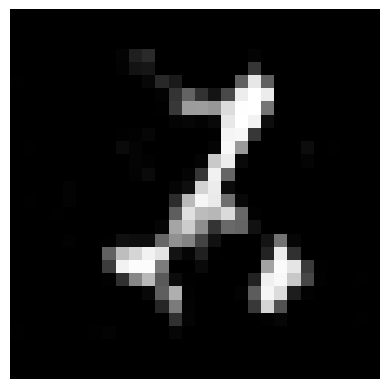

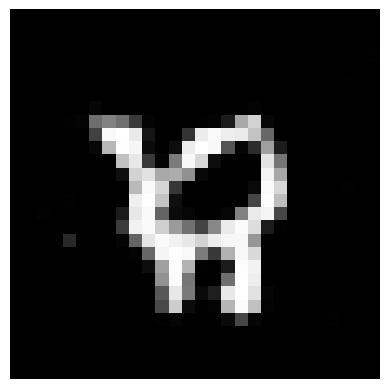

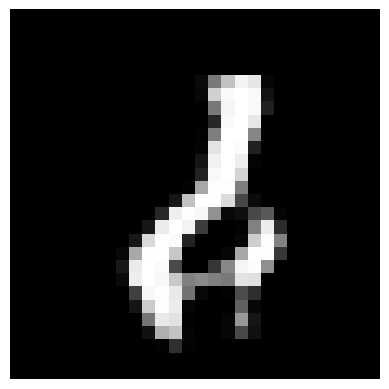

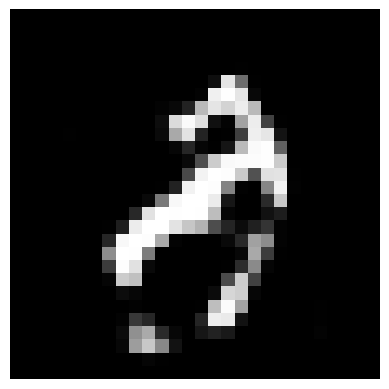

In [ ]:
# After training, you can visualize the generated images using the provided visualization function
image_size = 28
visualize_generated_images(generator_G, num_images=5)

In [ ]:
cnn_model = CNN()
cnn_model.eval()

# Define image preprocessing function
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ])


with torch.no_grad():
  for _ in range(5):
    # Generate a random input or use a sample from the test dataset
    random_input = torch.randn(1, 1, image_size, image_size).to(device)
    generated_image = generator_G(random_input)

    preprocessed_image = transform(generated_image)

    # Perform inference
    with torch.no_grad():
        cnn_model.to(device)
        preprocessed_image = preprocessed_image.to(device)
        output = cnn_model(preprocessed_image)

    # Process the output (e.g., obtain predicted class probabilities)
    predicted_probs = nn.functional.softmax(output, dim=1).squeeze().cpu().numpy()

    # Visualize the generated image and predicted probabilities
    plt.imshow(preprocessed_image.squeeze().cpu().numpy(), cmap='gray')
    plt.title(f'Predicted Probabilities: {predicted_probs}')
    plt.show()

___

In [ ]:
class CycleGANLayer(nn.Module):
    def __init__(self, generator_G, generator_F):
        super(CycleGANLayer, self).__init__()
        self.generator_G = generator_G
        #self.generator_F = generator_F

    def forward(self, inputs):
        translated_images_G = self.generator_G(inputs)
        #translated_images_F = self.generator_F(translated_images_G)
        return translated_images_G

In [ ]:
generator_G = CycleGANGenerator(input_channels=1)

# Move the generator to the appropriate device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator_G.to(device)

# Set the generator_G to evaluation mode
generator_G.eval()

CycleGANGenerator(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU(inplace=True)
  (residual_blocks): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=1e-05

---

# MNIST to USPS

In [ ]:
from zipfile import ZipFile
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/Semester 1/AI6121 Computer Vision/Group Project/'
# Specify the name of the uploaded zip file
zip_file_name = path + "mnist2usps.zip"
storepath = path + "dataset"


In [ ]:
# Extract the contents of the zip file
with ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(storepath)

# Check the extracted files
extracted_files = os.listdir(storepath)
print("Extracted Files:", extracted_files)

Extracted Files: ['mnist2usps']


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        # self.classes = os.listdir(folder_path)

        # self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.images = self._load_images()

    def _load_images(self):
        images = []
        # print(self.classes)
        # for cls in self.classes:
            # class_path = os.path.join(self.folder_path, cls)
        if os.path.isdir(self.folder_path):
            for img_name in os.listdir(self.folder_path):
                img_path = os.path.join(self.folder_path, img_name)
                label = img_path.split("/")[-1][0]
                images.append((img_path, label))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert("L")  # Convert to grayscale
        if self.transform:
            image = self.transform(image)
            label = torch.tensor(int(label))
            # label = transforms.ToTensor(label)


        return image, label

# Define data transformation
transform = transforms.Compose([
    Resize(size = (28,28)),
    Grayscale(),
    # transforms.RandomCrop(224),
    # transforms.RandomHorizontalFlip(),
    ToTensor(),
    Normalize(mean=[0.5], std=[0.5])

])

# Create a custom dataset
dataset = CustomDataset(folder_path=storepath + "/mnist2usps", transform=transform)

# Create a data loader
batch_size = 100
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True )

In [ ]:
print(len(dataset))

10000


In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Your convolutional layers go here
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        # Linear layer with dynamic input size
        self.out = nn.Linear(self._get_conv_output_size((1, 1, 28, 28)), 10)
        # Dropout layer to add regularization
        self.dropout = nn.Dropout(0.5)

    def _get_conv_output_size(self, shape):
        x = torch.rand(*shape)
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        return x.view(x.size(0), -1).shape[1]  # Return the number of features

    def forward(self, x):
        # Your forward pass code goes here
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)

        # Flatten the output of conv layers
        x = x.view(x.size(0), -1)

        # Linear layer
        output = self.out(x)

        return output

In [ ]:
# Instantiate the model
model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    for inputs, labels in data_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
 # Put the model in evaluation mode
model.eval()

# Initialize variables to track accuracy and loss
correct = 0
total = 0
test_loss = 0.0

# Iterate over the test dataset
with torch.no_grad():
    for inputs, labels in loaders['target']:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Update loss
        test_loss += loss.item()

        # Get predictions
        _, predicted = torch.max(outputs.data, 1)

        # Update accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(total)
# Calculate accuracy and average loss
accuracy = correct / total
average_loss = test_loss / len(loaders['target'])

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Average Test Loss: {average_loss:.4f}")

2007
Test Accuracy: 44.00%
Average Test Loss: 14.8366


In [ ]:
cnn_2 = CNN()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_2.parameters(), lr = 0.01)
num_epochs = 10

In [ ]:
train(num_epochs, cnn, loaders['test'])

Epoch [1/10], Step [100/100], Loss: 0.0534
Epoch [2/10], Step [100/100], Loss: 0.0318
Epoch [3/10], Step [100/100], Loss: 0.0023
Epoch [4/10], Step [100/100], Loss: 0.0810
Epoch [5/10], Step [100/100], Loss: 0.0024
Epoch [6/10], Step [100/100], Loss: 0.0658
Epoch [7/10], Step [100/100], Loss: 0.0019
Epoch [8/10], Step [100/100], Loss: 0.1584
Epoch [9/10], Step [100/100], Loss: 0.0422
Epoch [10/10], Step [100/100], Loss: 0.0040


In [ ]:
test(model = cnn , test_loader = loaders['target'])

Test Accuracy of the model on the 2007 test images: 0.68


In [ ]:
torch.save(cnn, path+"/source_cnn_0.68.pt")

In [ ]:
train(num_epochs, cnn_2, data_loader)

Epoch [1/10], Step [100/100], Loss: 0.1169
Epoch [2/10], Step [100/100], Loss: 0.0521
Epoch [3/10], Step [100/100], Loss: 0.0388
Epoch [4/10], Step [100/100], Loss: 0.1103
Epoch [5/10], Step [100/100], Loss: 0.1315
Epoch [6/10], Step [100/100], Loss: 0.0977
Epoch [7/10], Step [100/100], Loss: 0.0124
Epoch [8/10], Step [100/100], Loss: 0.0381
Epoch [9/10], Step [100/100], Loss: 0.0168
Epoch [10/10], Step [100/100], Loss: 0.0116


In [ ]:
test(model = cnn_2 , test_loader = loaders['target'])

Test Accuracy of the model on the 2007 test images: 0.89


In [ ]:
cnn_2 = torch.load(path+"/adapted_cnn_0.90.pt")

In [ ]:
cnn = torch.load(path+"source_cnn_0.68.pt")

In [ ]:
torch.save(cnn_2, path+"/adapted_cnn_0.90.pt")

In [ ]:
import cv2

In [ ]:
# read the images
img1 = cv2.imread('''/content/drive/MyDrive/Semester 1/AI6121 Computer Vision/Group Project/pytorch-CycleGAN-and-pix2pix/data/mnist_USPS/testA/0/00003.jpg''')
img2 = cv2.imread('''/content/drive/MyDrive/Semester 1/AI6121 Computer Vision/Group Project/dataset/mnist2usps/0_00003_fake_B.png''')

# vertically concatenates images
# of same width
# im_v = cv2.hconcat([img1, img2])
# show the output image
cv2_imshow(img1)

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
actual_number

array([9, 2, 1, 5, 1, 6, 4, 3, 4, 6])

In [ ]:
sample = next(iter(loaders['target']))
imgs, lbls = sample
actual_number = lbls[:10].numpy()

test_output, last_layer = cnn(imgs[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Source Model Prediction number:  {pred_y}')
test_output, last_layer = cnn_2(imgs[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()

print(f'Adapted Model Prediction number: {pred_y}')
print(f'Actual number:                   {actual_number}')

Source Model Prediction number:  [1 3 1 4 4 5 0 0 4 3]
Adapted Model Prediction number: [9 3 1 4 9 0 0 0 9 3]
Actual number:                   [9 3 1 4 9 0 0 0 9 3]
